In [ ]:
!nvidia-smi

Thu Oct 21 07:13:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path= "/content/drive/My Drive/understanding_cloud_organization/"

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf

In [ ]:
print(tf. __version__) 

1.15.2


In [ ]:
import matplotlib.image as mpimg                      
from skimage.measure import label, regionprops
import os, random, cv2, gc, math, matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
train_df        = pd.read_csv(path + 'train.csv')

#Splitting image_Label into image file name and images category 
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])

#checking whether images have masks or not
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

#replacing EncodedPixels NaN value by '00 00'
train_df['EncodedPixels'] = train_df['EncodedPixels'].apply(lambda x: '00 00' if type(x)==float else x)

In [ ]:
conditions = [ ( train_df['ClassId'].str.contains('Fish') & train_df['hasMask']== True), 
              ( train_df['ClassId'].str.contains('Flower') & train_df['hasMask']== True), 
              ( train_df['ClassId'].str.contains('Gravel') & train_df['hasMask']== True), 
              ( train_df['ClassId'].str.contains('Sugar') & train_df['hasMask']== True),
              ( train_df['hasMask']== False)
            ]

# images with NaN encodedPixels values will be labeled false
# images with numeric encodedPixels values will have the labels with their corresponding category
train_df['check'] = np.select(conditions, ['True_Fish', 'True_Flower','True_Gravel', 'True_Sugar', 'False' ])

train_df.head(5)

,Image_Label,EncodedPixels,ImageId,ClassId,hasMask,check
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True,True_Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True,True_Flower
2,0011165.jpg_Gravel,00 00,0011165.jpg,Gravel,False,False
3,0011165.jpg_Sugar,00 00,0011165.jpg,Sugar,False,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True,True_Fish


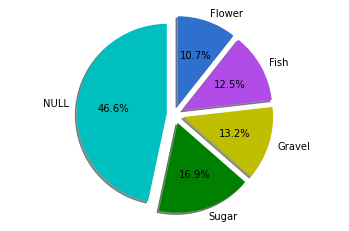

In [ ]:
y = train_df.check.value_counts()
mylabels = ['NULL', 'Sugar', 'Gravel', 'Fish', 'Flower']
colors = ['c', 'g', 'y', '#B14CE8','#3070CD']
plt.pie(y, labels = mylabels, 
        autopct='%1.1f%%', 
        colors = colors,
        explode = (0.09, 0.1, 0.1, 0.1, 0.1),
        shadow=True, 
        startangle=90)
plt.axis('equal')
plt.show() 

In [ ]:
# counting maximum number of masks in each image
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
print(mask_count_df.shape)
print(mask_count_df.head(100))

(5546, 2)
        ImageId  hasMask
0   0011165.jpg        2
1   002be4f.jpg        3
2   0031ae9.jpg        3
3   0035239.jpg        2
4   003994e.jpg        3
..          ...      ...
95  04fe809.jpg        3
96  05028f9.jpg        2
97  0502b9e.jpg        2
98  0505b52.jpg        2
99  050937d.jpg        2

[100 rows x 2 columns]


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

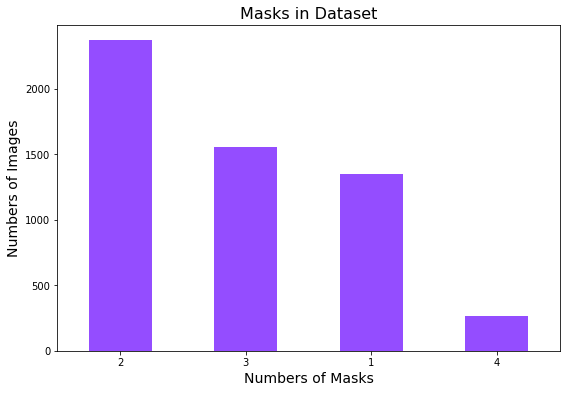

In [ ]:
plt.figure(figsize=(9, 6))
mask_count_df.hasMask.value_counts(dropna= False).plot(kind = 'bar', color='#944dff')
plt.ylabel('Numbers of Images', fontsize=14)
plt.xlabel('Numbers of Masks', fontsize=14)
plt.title('Masks in Dataset', fontsize=16)
plt.xticks(rotation=0)

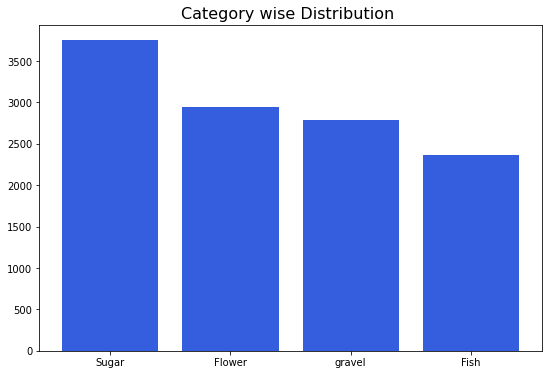

In [ ]:
#bargraph for number of images  each category
plt.figure(figsize=(9, 6))
categories = ['Sugar','Flower','gravel', 'Fish']
counts = train_df.check.value_counts()[1:]
plt.bar(categories, counts, color = '#355EDF')
plt.title('Category wise Distribution ', fontsize=16)
plt.show()

In [ ]:
def rle_to_mask(rleString,height= 1400,width= 2100):
  rows,cols = height,width
  rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
  rlePairs = np.array(rleNumbers).reshape(-1,2)
  img = np.zeros(rows*cols,dtype=np.uint8)
  for index,length in rlePairs:
    index -= 1
    img[index:index+length] = 255
  img = img.reshape(cols,rows)
  img = img.T
  return img



# converting rgb to grayscale image
def rgb_to_gray(img):
        grayImage = np.zeros(img.shape)
        R = np.array(img[:, :, 0])
        G = np.array(img[:, :, 1])
        B = np.array(img[:, :, 2])

        R = (R *.299)
        G = (G *.587)
        B = (B *.114)

        Avg = (R+G+B)
        grayImage = img.copy()

        for i in range(3):
           grayImage[:,:,i] = Avg
           
        return grayImage

In [ ]:
train_images = '/content/drive/MyDrive/understanding_cloud_organization/train_images'

In [ ]:
#creating rles
colors = [(0,0,255), (255,0,0), (0,255,0), (255,255,0)]
image_name = '0ff2c12.jpg'

rles = train_df[train_df['ImageId']==image_name]['EncodedPixels'].reset_index(drop=True)
image_start = plt.imread(os.path.join(train_images, image_name))
rles.head()

0                                                00 00
1    10 807 1410 807 2810 807 4210 807 5610 807 701...
2    456611 962 458011 962 459411 962 460811 962 46...
3    2196606 397 2198006 397 2199406 397 2200806 39...
Name: EncodedPixels, dtype: object

In [ ]:
def trace_boundingBox(image : np.ndarray,
                      mask : np.ndarray,
                      color : tuple = (0,0,255),
                      width : int = 27):
    """
    Draw a bounding box on image

     Parameter
     ----------
     image : image on which we want to draw the box 
     mask  : mask to process
     color : color we want to use to draw the box edges
     width : box edges's width

    """
    
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        coin1 = (prop.bbox[3], prop.bbox[2])
        coin2 = (prop.bbox[1], prop.bbox[0])
        cv2.rectangle(image, coin2, coin1, color, width)
        # cv2.putText(image,'text', (prop.bbox[3], prop.bbox[2]+30), cv2.FONT_HERSHEY_SIMPLEX, 10, (0,255,0), 2)

In [ ]:
labels = ['NULL', 'Sugar', 'Gravel', 'Fish', 'Flower']

In [ ]:
import warnings
from tqdm import tqdm_notebook
import tensorflow as tf
try:
    from tensorflow.contrib import keras as keras
    print ('load keras from tensorflow package')
except:
    print ('update your tensorflow')
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers

from keras import backend as K
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
warnings.filterwarnings("ignore")

load keras from tensorflow package


Using TensorFlow backend.


In [ ]:
img_width   = 128 
img_height  = 128
num_classes = 4
tr          = pd.read_csv(path + 'train.csv')
print(len(tr))
tr.head()

22184


,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [ ]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

img_names_all = tr['Image_Label'].apply(lambda x: x.split('_')[0]).unique()
len(img_names_all)

5546

In [ ]:
new_ep = True
def keras_generator(batch_size):  
    global new_ep
    while True:   
        
        x_batch = []
        y_batch = []        
        for _ in range(batch_size):                         
            if new_ep == True:
                img_names =  img_names_all
                new_ep = False
            
            fn = img_names[random.randrange(0, len(img_names))]                                   

            img = cv2.imread(path + 'train_images/'+ fn)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                       
            masks = []
            for rle in tr[tr['Image_Label'].apply(lambda x: x.split('_')[0]) == fn]['EncodedPixels']:                
                if pd.isnull(rle):
                    mask = np.zeros((img_width, img_height))
                else:
                    mask = rle2mask(rle, img.shape)
                    mask = cv2.resize(mask, (img_width, img_height))
                masks.append(mask)                                        
            img = cv2.resize(img, (img_width, img_height))            
            x_batch += [img]
            y_batch += [masks] 

            img_names = img_names[img_names != fn]   
 
        x_batch = np.array(x_batch)
        y_batch = np.transpose(np.array(y_batch), (0, 2, 3, 1))        

        yield x_batch, y_batch

In [ ]:

def get_model():
    inputs = Input((img_width,img_height, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])

    return model

model = get_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1

In [ ]:
class EpochBegin(keras.callbacks.Callback):
    def on_epoch_begin (self, epoch, logs={}):
        global new_ep
        new_ep = True
Epoch_Begin_Clb = EpochBegin()

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='loss',
                              mode='auto',
                              factor=0.666,
                              patience=1,
                              min_lr=0,
                              cooldown=0,
                              verbose=1)


In [ ]:
%%time
batch_size=16
history = model.fit_generator(keras_generator(batch_size),
              steps_per_epoch=200,                    
              epochs=3,
              callbacks=[Epoch_Begin_Clb])


Epoch 1/3
200/200 [==============================] - 1309s 7s/step - loss: 0.5108 - accuracy: 0.8353
Epoch 2/3
200/200 [==============================] - 704s 4s/step - loss: 0.4518 - accuracy: 0.8487
Epoch 3/3
200/200 [==============================] - 477s 2s/step - loss: 0.4281 - accuracy: 0.8487
CPU times: user 15min 32s, sys: 27 s, total: 15min 59s
Wall time: 41min 32s


In [ ]:
%%time
test_img = []
testfiles=os.listdir(path + 'test_images/')
for fn in tqdm_notebook(testfiles):     
        img = cv2.imread( path + 'test_images/'+fn )
        img = cv2.resize(img,(img_width, img_height))       
        test_img.append(img)
len(test_img)

  0%|          | 0/3698 [00:00<?, ?it/s]

CPU times: user 2min 49s, sys: 6.06 s, total: 2min 55s
Wall time: 3min 19s


In [ ]:
%%time
predict = model.predict(np.asarray(test_img))

CPU times: user 15.3 s, sys: 1.14 s, total: 16.4 s
Wall time: 15.1 s


In [ ]:
predict.shape

(3698, 128, 128, 4)

In [ ]:
pred_rle[0]

'1 3 58 4 63 58 165 3 180 1 183 55 332 3 337 17 408 4 413 58 515 3 530 1 533 55 682 3 687 17 758 4 763 59 866 2 880 1 883 55 1016 1 1031 23 1109 3 1113 59 1216 1 1229 3 1234 54 1355 3 1360 2 1366 2 1381 18 1401 3 1459 65 1566 1 1579 3 1584 54 1704 14 1730 19 1751 3 1768 3 1809 67 1929 3 1934 54 1997 3 2053 16 2073 3 2079 17 2101 3 2118 3 2159 67 2279 3 2283 55 2342 3 2346 4 2353 1 2402 17 2421 6 2428 18 2451 3 2468 4 2509 66 2629 59 2692 13 2752 17 2770 26 2801 4 2819 4 2859 65 2963 2 2979 59 3042 13 3102 17 3120 27 3151 7 3164 4 3170 4 3182 1 3209 65 3290 3 3296 3 3313 2 3329 59 3392 13 3453 16 3470 27 3501 7 3514 4 3520 5 3531 3 3559 60 3620 4 3640 3 3646 3 3663 2 3669 1 3680 75 3803 16 3820 28 3851 4 3862 6 3872 3 3908 66 3990 3 3995 4 4013 2 4018 2 4024 1 4030 76 4108 2 4152 45 4201 3 4212 7 4223 3 4258 66 4333 2 4340 8 4355 1 4363 1 4368 2 4373 3 4380 76 4458 3 4502 44 4549 5 4562 4 4567 2 4573 3 4585 1 4607 67 4682 3 4689 2 4692 6 4704 3 4718 3 4722 4 4730 1 4733 62 4797 9 4808 3

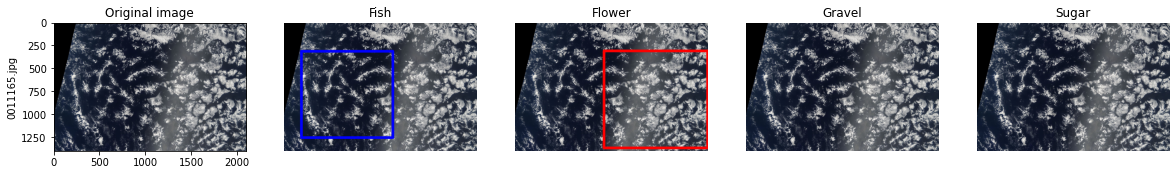

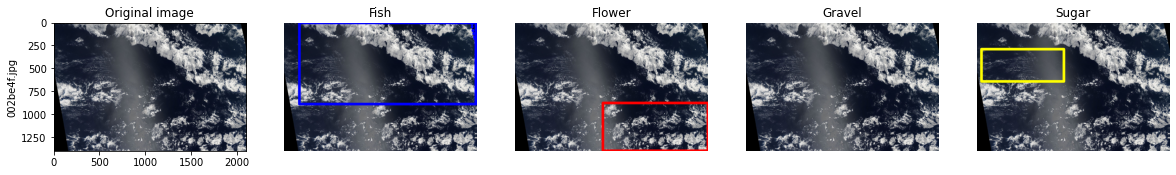

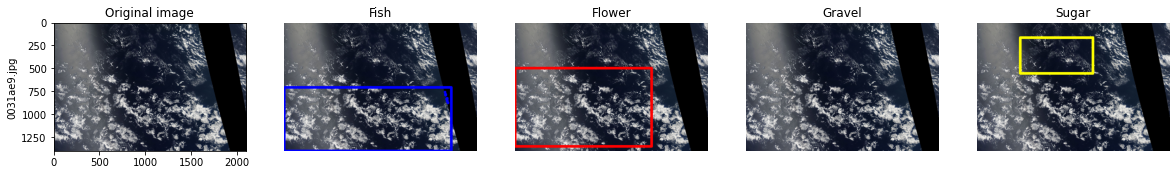

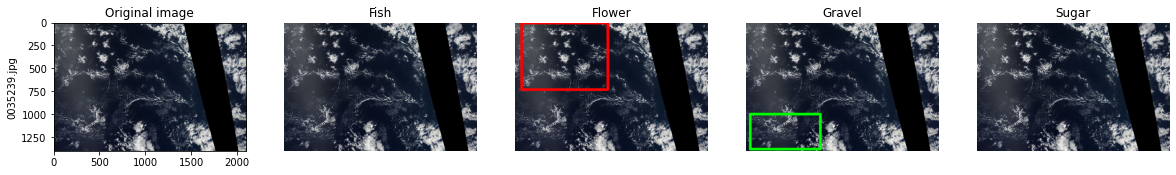

In [ ]:
colors = [(0,0,255), (255,0,0), (0,255,0), (255,255,0)]  # B, R ,G, Y colors

#subplots
for i in range(0, 13, 4):
  plt.figure(figsize=(20, 10))                                  
      
  image_name = train_df.loc[train_df.index[i]]['ImageId']       # fetching image name
  image = mpimg.imread(os.path.join(train_images, image_name))  # storing image in the form of np.array

  # ploting original image
  plt.subplot(2, 5, 1)                                           # 1st picture of 1st row
  plt.title('Original image')
  plt.imshow(image)
  plt.ylabel(train_df.loc[train_df.index[i]]['ImageId'])         # name of first image

  # Detecting fish pattern in image
  plt.subplot(2, 5, 2)                                           # 2nd picture of 1st row
  rle = df.loc[df.index[i]]['EncodedPixels']         # initialize the current RLE code
  if not isinstance(rle, float):                                 # it's not a 'NaN' RLE
      mask = rle_to_mask(rle)                                    
      trace_boundingBox(image, mask, color=colors[0])            # draw boundingBox on original image with blue color
  plt.title(df.loc[df.index[i]]['ClassId'])
  plt.imshow(image)
  plt.axis(False)                                              


  # Detecting flower pattern in image
  image = mpimg.imread(os.path.join(images, image_name))    
  plt.subplot(2, 5, 3)
  rle = df.loc[df.index[i+1]]['EncodedPixels']                    
  if not isinstance(rle, float):                                             
      mask = rle_to_mask(rle)
      trace_boundingBox(image, mask, color=colors[1])
  plt.title(df.loc[df.index[i+1]]['ClassId'])
  plt.imshow(image)
  plt.axis(False)

  # Detecting gravel pattern in image
  image = mpimg.imread(os.path.join(images, image_name))
  plt.subplot(2, 5, 4)
  rle = df.loc[df.index[i+2]]['EncodedPixels']                   
  if not isinstance(rle, float):
      mask = rle_to_mask(rle)
      trace_boundingBox(image, mask, color=colors[2])
  plt.title(df.loc[df.index[i+2]]['ClassId'])
  plt.imshow(image)
  plt.axis(False)

  # Detecting sugar pattern in image
  image = mpimg.imread(os.path.join(images, image_name))
  plt.subplot(2, 5, 5)
  rle = df.loc[df.index[i+3]]['EncodedPixels']                   
  if not isinstance(rle, float): 
      mask = rle_to_mask(rle)
      trace_boundingBox(image, mask, color=colors[3])
  plt.title(df.loc[df.index[i+3]]['ClassId'])

  plt.imshow(image)
  plt.axis(False)




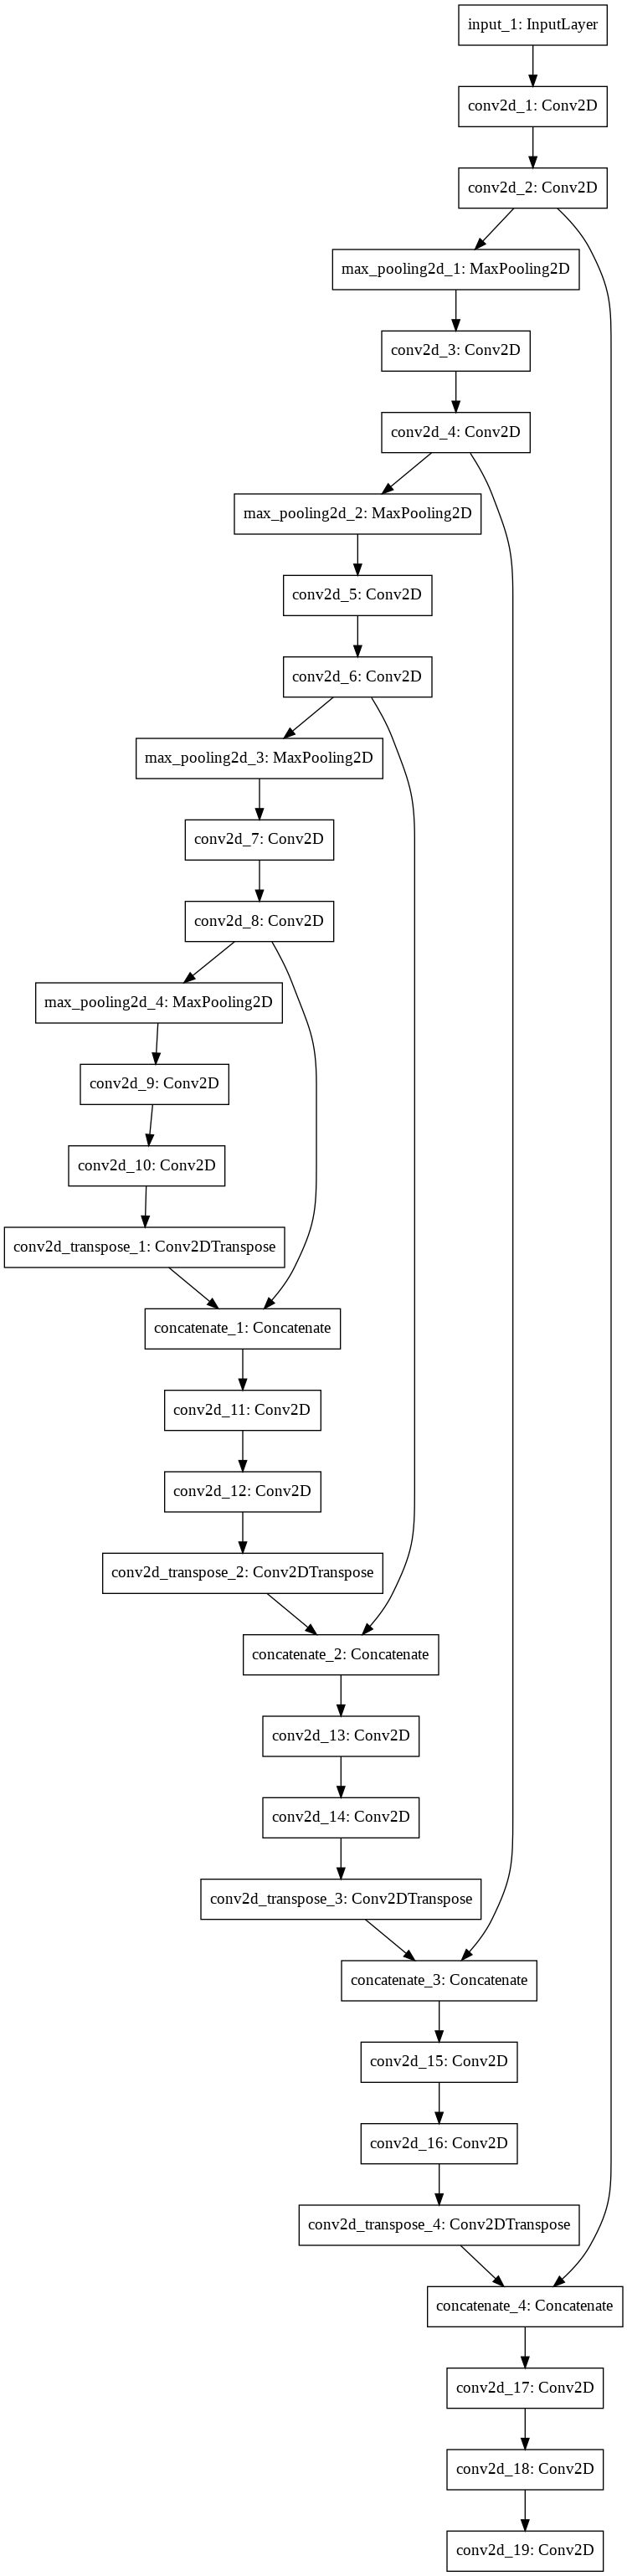

In [ ]:
plot_model(
    model,
    to_file="model layers.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB"
)

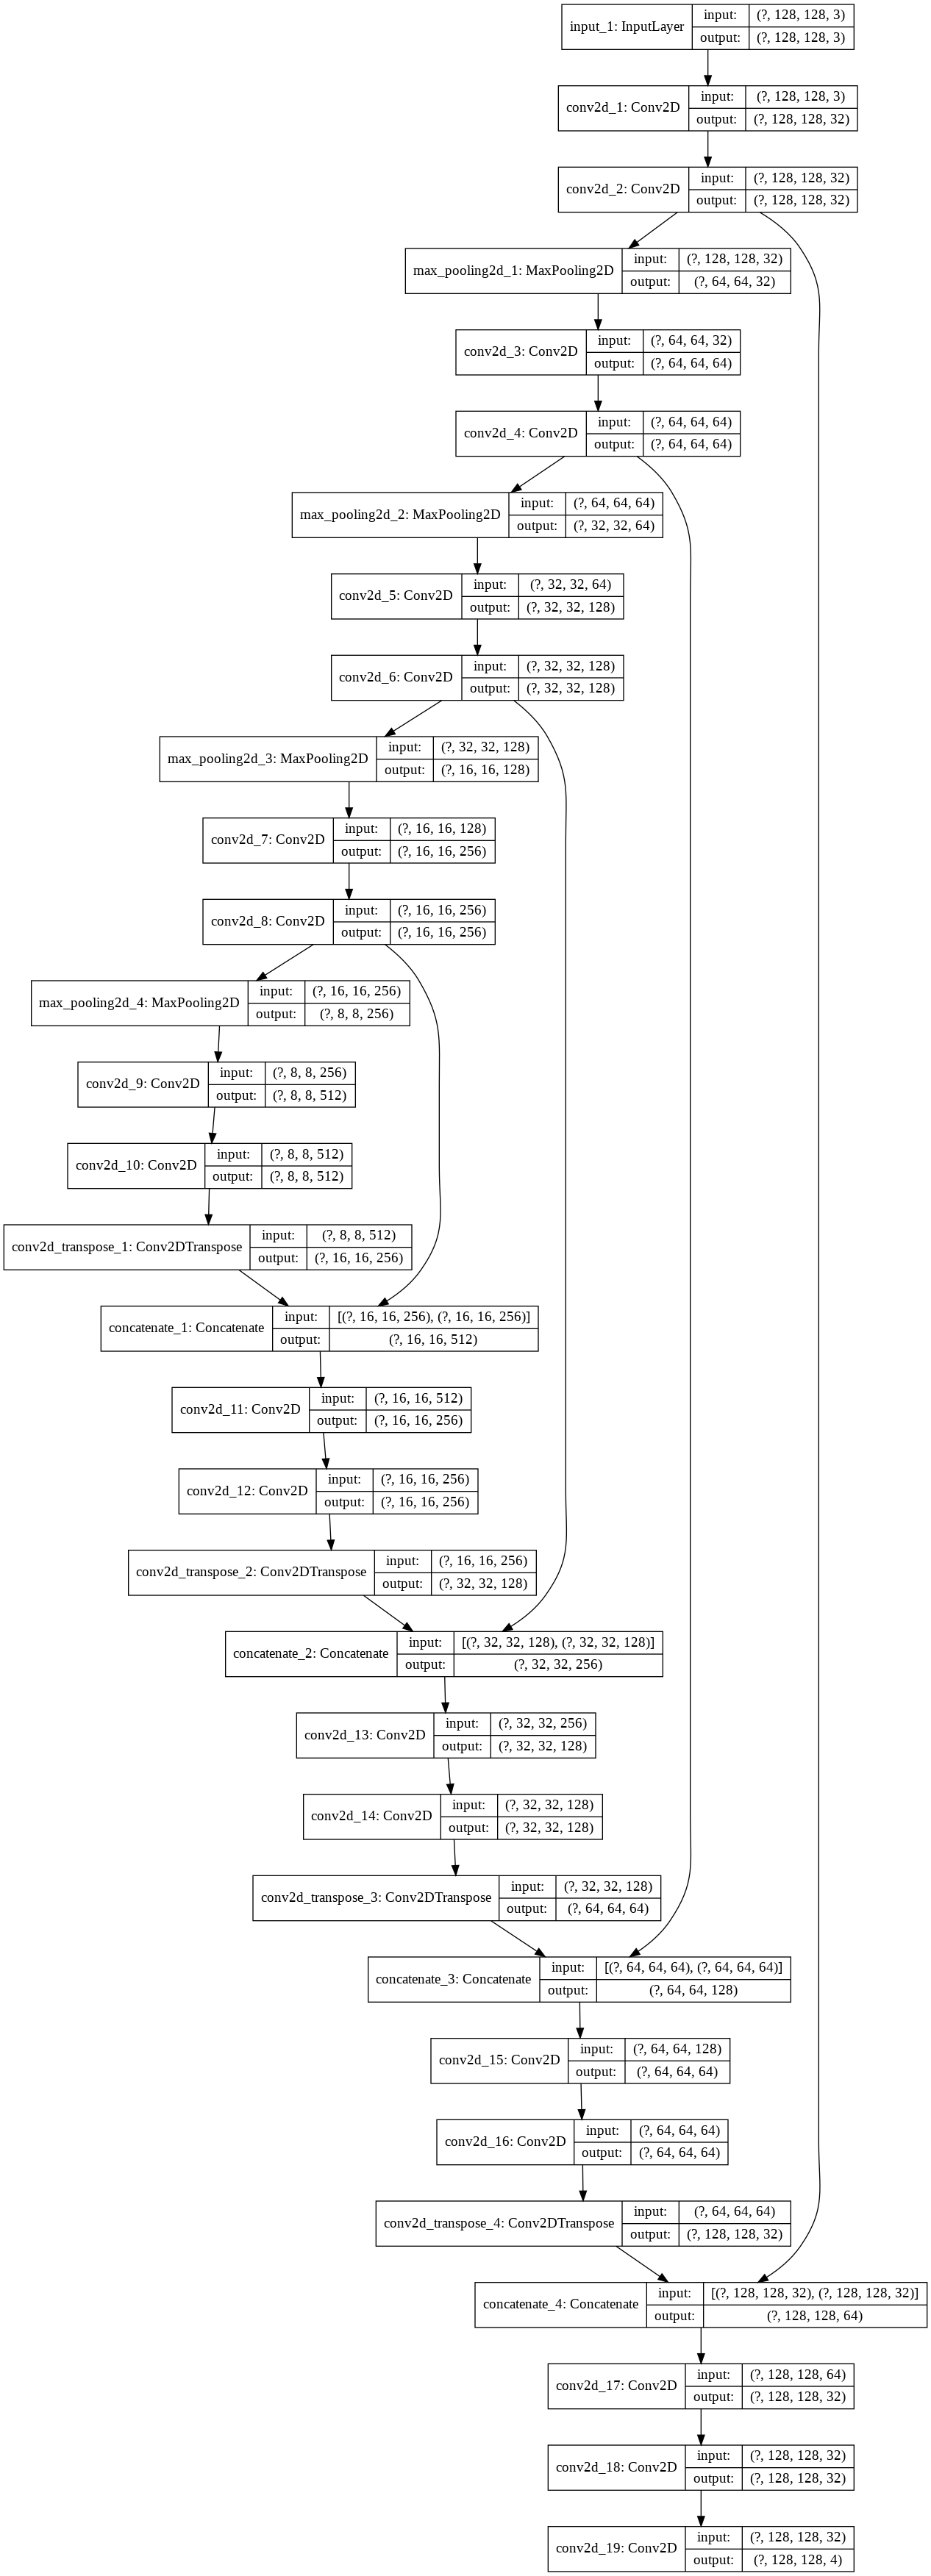

In [ ]:
# plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model architecture.png',show_shapes=True)

In [ ]:
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
#     model.compile(optimizer=Adam(lr=0.001), loss=dice_coef_loss, metrics=[dice_coef])

In [ ]:
# # save model
# from keras.models import model_from_json
# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

In [ ]:
# #load json and create model
# from keras.models import model_from_json
# json_file = open('model_3_epochs.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# model.summary()

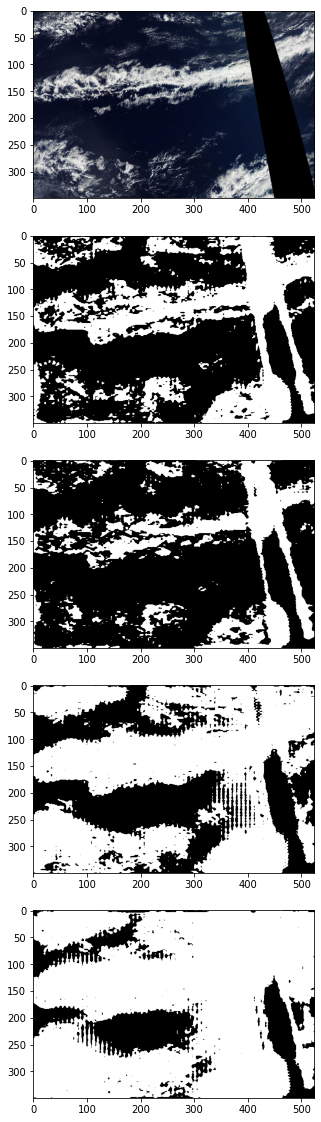

In [ ]:
fig, axs = plt.subplots(5, figsize=(20, 20))
axs[0].imshow(cv2.resize(plt.imread(path + 'test_images/' + testfiles[0]),(525, 350)))
for i in range(4):
    axs[i+1].imshow(rle2mask(pred_rle[i], img.shape), cmap = "Greys")

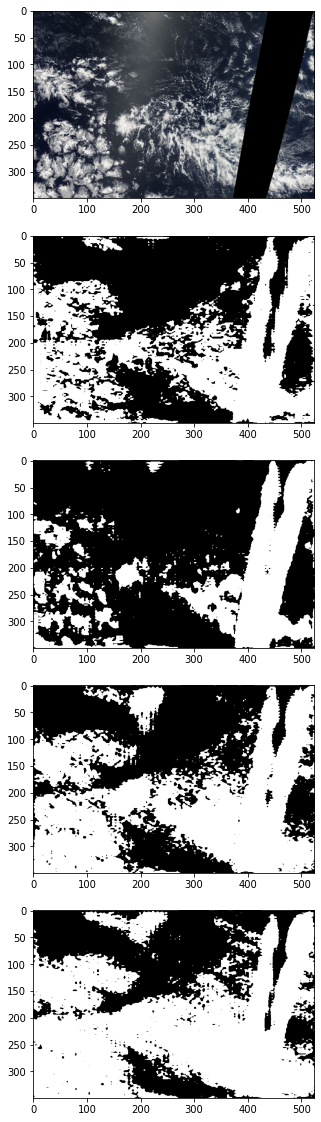

In [ ]:
fig, axs = plt.subplots(5, figsize=(20, 20))
axs[0].imshow(cv2.resize(plt.imread(path + 'test_images/' + testfiles[1]),(525, 350)))
k=4
for i in range(4):
    axs[i+1].imshow(rle2mask(pred_rle[k], img.shape), cmap = "Greys")
    k= k+1

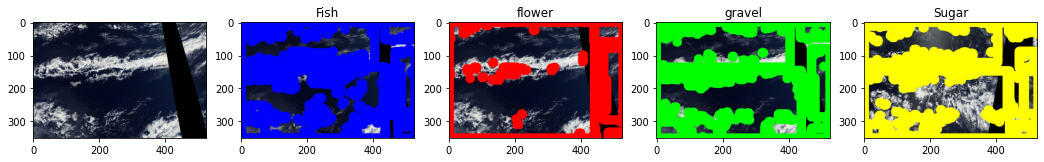

In [ ]:
plt.figure(figsize=(18, 10))
    
plt.subplot(2, 5, 1) 
img = cv2.resize(plt.imread(path + 'test_images/' + testfiles[0]),(525, 350))
plt.imshow(img)


# fish
plt.subplot(2, 5, 2)  
mask = rle2mask(pred_rle[0], img.shape)
img = cv2.resize(plt.imread(path + 'test_images/' + testfiles[0]),(525, 350))
trace_boundingBox(img, mask, color=colors[0])
plt.title("Fish")
plt.imshow(img)

# flower
plt.subplot(2, 5, 3)  
mask = rle2mask(pred_rle[1], img.shape)
img = cv2.resize(plt.imread(path + 'test_images/' + testfiles[0]),(525, 350))
trace_boundingBox(img, mask, color=colors[1])
plt.title("flower")
plt.imshow(img)

#gravel
plt.subplot(2, 5, 4)  
mask = rle2mask(pred_rle[2], img.shape)
img = cv2.resize(plt.imread(path + 'test_images/' + testfiles[0]),(525, 350))
trace_boundingBox(img, mask, color=colors[2])
plt.title("gravel")
plt.imshow(img)

#sugar
plt.subplot(2, 5, 5)  
mask = rle2mask(pred_rle[3], img.shape)
img = cv2.resize(plt.imread(path + 'test_images/' + testfiles[1]),(525, 350))
trace_boundingBox(img, mask, color=colors[3])
plt.title("Sugar")
plt.imshow(img)



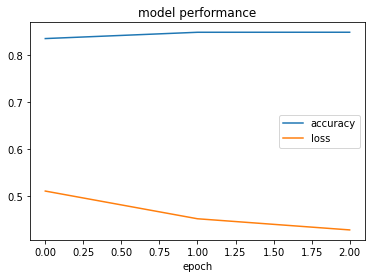

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model performance')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='right')
plt.savefig('model performance.png')

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


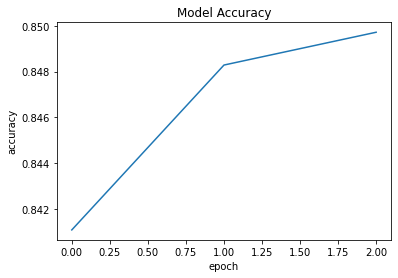

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.savefig('accuracy curve.png')

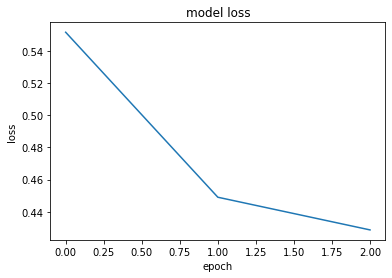

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig('loss curve.png')

In [ ]:
gc.collect()

2866

In [ ]:
sub = pd.read_csv( path + 'sample_submission.csv', converters={'EncodedPixels': lambda e: ' '} )
sub['EncodedPixels'] = pred_rle
sub.head()

NameError: ignored

In [ ]:
sub.to_csv('submission.csv', index=False)

In [ ]:
fig, axs = plt.subplots(5, figsize=(20, 20))
axs[0].imshow(cv2.resize(plt.imread(path + 'test_images/' + testfiles[0]),(525, 350)))
for i in range(4):
    axs[i+1].imshow(rle2mask(pred_rle[i], img.shape),cmap ='gray')

In [ ]:
%%time
pred_rle = []
for img in predict:   
    img = cv2.resize(img, (525, 350))
    tmp = np.copy(img)
    tmp[tmp<np.mean(img)] = 0
    tmp[tmp>0] = 1
    for i in range(tmp.shape[-1]):
        pred_rle.append(mask2rle(tmp[:,:,i]))
len(pred_rle)

CPU times: user 2min 29s, sys: 3.19 s, total: 2min 33s
Wall time: 2min 30s


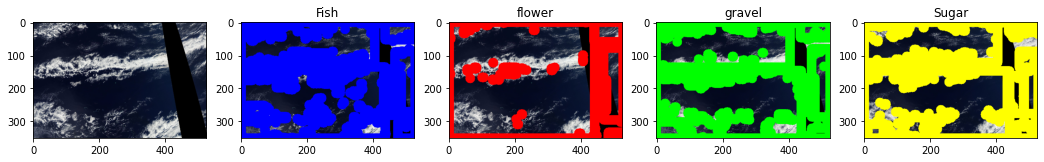

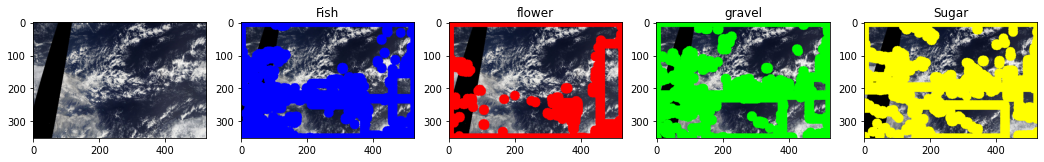

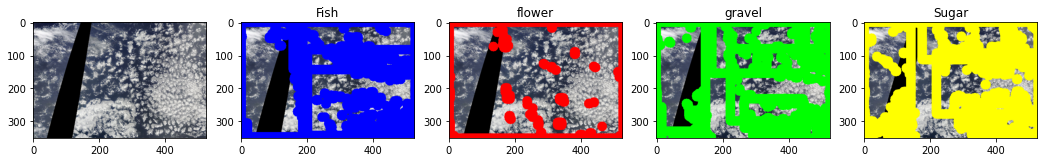

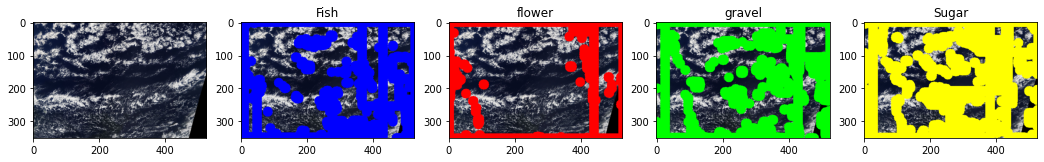

In [ ]:
import matplotlib.image as mpimg 
colors = [(0,0,255), (255,0,0), (0,255,0), (255,255,0)]  # B, R ,G, Y colors
for i in range(0, 13, 4):
    plt.figure(figsize=(18, 10))
    
    plt.subplot(2, 5, 1) 
    img = cv2.resize(plt.imread(path + 'test_images/' + testfiles[i]),(525, 350))
    plt.imshow(img)


    # fish
    plt.subplot(2, 5, 2)  
    mask = rle2mask(pred_rle[0+i], img.shape)
    img = cv2.resize(plt.imread(path + 'test_images/' + testfiles[i]),(525, 350))
    trace_boundingBox(img, mask, color=colors[0])
    plt.title("Fish")
    plt.imshow(img)

    # flower
    plt.subplot(2, 5, 3)  
    mask = rle2mask(pred_rle[i+1], img.shape)
    img = cv2.resize(plt.imread(path + 'test_images/' + testfiles[i]),(525, 350))
    trace_boundingBox(img, mask, color=colors[1])
    plt.title("flower")
    plt.imshow(img)

    #gravel
    plt.subplot(2, 5, 4)  
    mask = rle2mask(pred_rle[2+i], img.shape)
    img = cv2.resize(plt.imread(path + 'test_images/' + testfiles[i]),(525, 350))
    trace_boundingBox(img, mask, color=colors[2])
    plt.title("gravel")
    plt.imshow(img)

    #sugar
    plt.subplot(2, 5, 5)  
    mask = rle2mask(pred_rle[i+3], img.shape)
    img = cv2.resize(plt.imread(path + 'test_images/' + testfiles[i]),(525, 350))
    trace_boundingBox(img, mask, color=colors[3])
    plt.title("Sugar")
    plt.imshow(img)



In [ ]:
from skimage.measure import label, regionprops
def trace_boundingBox(image : np.ndarray,
                      mask : np.ndarray,
                      color : tuple = (0,0,255),
                      width : int = 27):
    """
    Draw a bounding box on image

     Parameter
     ----------
     image : image on which we want to draw the box 
     mask  : mask to process
     color : color we want to use to draw the box edges
     width : box edges's width

    """
    
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        coin1 = (prop.bbox[3], prop.bbox[2])
        coin2 = (prop.bbox[1], prop.bbox[0])
        cv2.rectangle(image, coin2, coin1, color, width)
